# Line Extending Game 0
Here, we:
1. Introduce the "two-pixel line extending game"
2. Use reinforcement learning to learn to play the game
3. Use reinforcement learning to learn *rules* to play the game

Throughout the notebook, helper functions whose implementations are not important are factored out into a library file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import warnings
import time
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from nsai_experiments import line_extending_game_tools as lgt

## 1: The two-pixel line extending game

Imagine a NxN grid of pixels that can either be on (`x`) or off (`-`), represented by a NumPy Boolean array:

In [3]:
sample_grid = lgt.create_grid("""
    - - - - -
    x - - - -
    x - - x -
    - - x - -
    - - - - -
    """)
print(sample_grid)
lgt.display_grid(sample_grid)

[[False False False False False]
 [ True False False False False]
 [ True False False  True False]
 [False False  True False False]
 [False False False False False]]
- - - - -
x - - - -
x - - x -
- - x - -
- - - - -


The game is: for every "line segment" consisting of at least two contiguous `x`s, extend the segment all the way across the grid. For instance:

In [4]:
sample_start1 = lgt.create_grid("""
    - - - - - - - - - - 
    - - x - - x - - - - 
    - x - - x - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - x x - 
    - - - - - - - - - - 
    """)

sample_final1 = lgt.create_grid("""
    - - - x - - x - - - 
    - - x - - x - - - - 
    - x - - x - - - - - 
    x - - x - - - - - - 
    - - x - - - - - - - 
    - x - - - - - - - - 
    x - - - - - - - - - 
    - - - - - - - - - - 
    x x x x x x x x x x 
    - - - - - - - - - -  
    """)

lgt.display_grid(sample_start1)
print()
lgt.display_grid(sample_final1)

- - - - - - - - - -
- - x - - x - - - -
- x - - x - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - x x -
- - - - - - - - - -

- - - x - - x - - -
- - x - - x - - - -
- x - - x - - - - -
x - - x - - - - - -
- - x - - - - - - -
- x - - - - - - - -
x - - - - - - - - -
- - - - - - - - - -
x x x x x x x x x x
- - - - - - - - - -


The game is played in moves, where each move consists of changing one `-` to an `x`. For simplicity in this very basic version of the game, we disallow starting states that correspond to final states containing line segments not part of a line. For instance, this is disallowed:

In [5]:
bad_start = lgt.create_grid("""
    - - - - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - - - - - - - - -
    - - - - - - - - - -
    - - - - - - - - - -
    - - - - - - - - - -
    - - - - - - - - - -
    - - - - - - x x - -
    - - - - - - - - - -
    """)

bad_final = lgt.create_grid("""
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    x x x x x x x x x x
    - - x - - - - - - -
    """)

lgt.display_grid(bad_start)
print()
lgt.display_grid(bad_final)

- - - - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - x x - -
- - - - - - - - - -

- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
x x x x x x x x x x
- - x - - - - - - -


because its final state contains several diagonal line segments not part of lines. For the two-pixel version, this means that, with a few exceptions, lines cannot touch each other. This rule gives our game the useful property that if grid A can be transformed into grid B with one move, a solution for grid B plus that one move is a solution for grid A.

### A Human Solution

With this convenient modification, an intuitive solution to the game is: whenever you see a line segment, extend it on one of the ends if possible; repeat until no more moves are possible; then the game is solved. Here's an implementation of that:

In [6]:
"""
Takes a segment and direction and outputs the coordinates of the points on each end of the
segment that we'd want to extend
"""
def where_to_extend(segment, direction):
    (a, b), (c, d) = segment
    match direction:
        case "HORIZONTAL": return (a, b-1), (c, d+1)
        case "VERTICAL":   return (a-1, b), (c+1, d)
        case "SLOPE_DOWN": return (a-1, b-1), (c+1, d+1)
        case "SLOPE_UP":   return (a+1, b-1), (c-1, d+1)

def solve_human(unsolved_problem, timeout = 100, random_seed = 47, print_status = False):
    random.seed(random_seed)
    rows, cols = np.shape(unsolved_problem)
    answer = np.copy(unsolved_problem)
    # Each iteration is a move in the game; note that we only need to refer to the current state (not the starting state) to find the next move
    for i in range(timeout):
        # Find all possible line segments and the points we'd want to fill in to extend those segments
        segments, directions = lgt.find_all_segments(answer)
        possible_moves = [point
                              for (segment, direction) in zip(segments, directions)
                                  for point in where_to_extend(segment, direction)]
        
        # Exclude points that are off the board and points that have already been filled in
        if print_status: print(f"{len(possible_moves)} initial possible moves... ", end = "")
        possible_moves = list(filter(lambda point: 0 <= point[0] < rows and 0 <= point[1] < cols, possible_moves))
        if print_status: print(f"down to {len(possible_moves)} due to out of bounds... ", end = "")
        possible_moves = list(filter(lambda point: not answer[point[0], point[1]], possible_moves))
        if print_status: print(f"down to {len(possible_moves)} due to already filled in")
        
        # End or choose a random move from the possible points
        if len(possible_moves) == 0:
            if print_status: print(f"Success after {i+1} iterations!")
            return answer
        my_move = random.choice(possible_moves)
        answer[my_move] = True
    if print_status: print(f"Timed out after {timeout} iterations")
    return answer

lgt.display_grid(sample_start1)
human_answer = solve_human(sample_start1, print_status = True)
lgt.display_grid(human_answer)

assert np.array_equal(human_answer, sample_final1)

- - - - - - - - - -
- - x - - x - - - -
- x - - x - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - x x -
- - - - - - - - - -
6 initial possible moves... down to 6 due to out of bounds... down to 6 due to already filled in
8 initial possible moves... down to 7 due to out of bounds... down to 5 due to already filled in
10 initial possible moves... down to 9 due to out of bounds... down to 5 due to already filled in
12 initial possible moves... down to 11 due to out of bounds... down to 5 due to already filled in
14 initial possible moves... down to 12 due to out of bounds... down to 4 due to already filled in
16 initial possible moves... down to 14 due to out of bounds... down to 4 due to already filled in
18 initial possible moves... down to 15 due to out of bounds... down to 3 due to already filled in
20 initial possible moves... down to 16 due to out of bounds... down to 2 due to already filled in
22 initial po

Obviously this is not the most efficient solution — we are starting completely from scratch every iteration and, for most of the game, most of the candidate moves are already filled in — but it is easy to understand. Let's generate some (problem, solution) pairs and test that the algorithm works:

In [7]:
lgt.display_grid(lgt.generate_problem(10, 10, 2, 2, 2)[0])

- - - - - - - - - -
- - x - - - - x - -
- x - x - - - - - x
x - - - - - - - x -
- - - - - - - x - -
- - - - - - x - - -
- x - - - - - x - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -


In [8]:
random.seed(47)
for i in range(100):
    # Generate a problem with the given dimensions and number of three-length segments,
    # two-length features, and one-length features; and the corresponding solution
    problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
    assert np.array_equal(solve_human(problem), solution)

## 2: A Reinforcement Learning Player
Now let's use traditional reinforcement learning to teach an agent how to play the game. The development of this RL agent turned out to require some iteration, so I factored that process out into `line_extending_trad_rl.ipynb`. Here, I'll describe the more or less successful design I ended up with.

We imagine an agent moving around the board, turning on all the pixels it deems necessary in a certain area before moving on. We'll give the agent a "view" of a 5x5 square centered on the active pixel (thereby encoding "for free" the knowledge that what to do for each pixel depends only on the values of pixels a maximum of 2 pixels away) and let it make two actions: turn on the pixel or move to the next cell. We'll also give the agent for free that it is not possible to activate a pixel that is already activated. We will drag this agent across the entire board until it makes a full pass without activating any pixels.

The agent's policy is represented by a table where the rows are each possible state — all $2^{5*5-1} = 16,777,216$ of them — the columns are each possible action — either fill in the active pixel or move on — and the values are the quality of taking that action given that state. (In practice, we'll use two tables so that we can normalize values by the number of times they were trained.) For training, we'll use an exploration policy that initially makes random decisions biased towards the "move on" action and starts to follow the real policy closer and closer as training proceeds. We'll consider the training agent done with a given grid when it has activated the same number of pixels as are activated in the answer and then made a full pass over the grid after that. We will then compare the agent-generated grid to the solution grid and use the value of each pixel to update the decisions that influenced that pixel.


In [9]:
# Created from the successful agent we ended up with in `line_extending_trad_rl.ipynb`
class WorkingTraditionalAgent:
    """
    Initialize the agent for a grid with `n_rows` rows and `n_cols` cols; give it a state
    window of height `window_rows*2+1` and width `window_cols*2+1`; call `random_source` for
    a source of randomness.
    """
    def __init__(self, *, window_rows = 2, window_cols = 2, random_source = random.random):
        self._window_rows = window_rows
        self._window_cols = window_cols
        self._random_source = random_source
        # PERF might be better to store these together for better caching performance
        # Rows are state, cols are action (0 = move on, 1 = fill in), vals are q-value numerator
        self._q_table = np.zeros((2**((window_rows*2+1)*(window_cols*2+1)-1), 2), dtype=np.int64)
        # Rows are state, cols are action, vals are # of times encountered in training data
        self._times_encountered = np.zeros_like(self._q_table)
        self._cells_traversed = 0
    
    """
    Set the grid that the agent operates on; place the agent at the top left corner. Creates
    a copy of the grid; subsequent operations will not mutate the original.
    """
    def set_grid(self, grid):
        self._n_rows, self._n_cols = grid.shape
        # Probability of moving on during exploration. Chosen so that 10% of cells
        # are filled in after max(n_rows, n_cols) full passes over the grid
        self._exploration_bias = 1 - 0.1/max(self._n_rows, self._n_cols)
        assert np.shape(grid) == (self._n_rows, self._n_cols)
        self._padded_grid = np.pad(grid, ((self._window_rows, self._window_rows), (self._window_cols, self._window_cols)))
        self._my_row = 0
        self._my_col = 0
        self._actions_taken = []
        self._action_locations = []

    "Mark the current cell as on"
    def activate_current_cell(self):
        self._padded_grid[self._window_rows+self._my_row, self._window_cols+self._my_col] = True

    "Read the current cell"
    def read_current_cell(self):
        return self._padded_grid[self._window_rows+self._my_row, self._window_cols+self._my_col]
    
    "Get the grid with whatever modifications the agent has made to it so far"
    def get_grid(self):
        return self._padded_grid[self._window_rows:-self._window_rows, self._window_cols:-self._window_cols]
    
    "Count the total number of filled cells in the current grid"
    def count_filled_cells(self):
        return np.sum(self.get_grid())
    
    "Get the current agent state as a grid centered on the active cell (which is technically not part of the state)"
    def current_state_grid(self):
        return self._padded_grid[
            self._my_row:self._my_row+self._window_rows*2+1,
            self._my_col:self._my_col+self._window_cols*2+1]
    
    "Use binary to encode the current agent state as an integer for `q_table` indexing"
    def _state_grid_to_n(self, state_grid):
        tr, tc = self._window_rows*2+1, self._window_cols*2+1
        assert np.shape(state_grid) == (tr, tc)
        # Remove the center cell, which is not part of the state
        # PERF could do this afterwards with bit twiddling
        without_center_cell = np.delete(state_grid.flatten(), tc*self._window_rows+self._window_cols)
        return without_center_cell.dot(2**np.arange(tr*tc-1)[::-1])
    
    "Apply the exploration policy to the state grid `s` to produce an action"
    def exploration_policy(self, s):
        if self._random_source() < self._exploration_rate:
            return int(self._random_source() >= self._exploration_bias)
        return self.real_policy(s)
    
    "Apply the real policy to the state grid `s` to produce an action"
    def real_policy(self, s):
        idx = self._state_grid_to_n(s)
        q_row = self._q_table[idx]
        te_row = self._times_encountered[idx]
        with np.errstate(invalid = "ignore"): q_quotient = q_row/te_row
        if len(q_quotient[np.isnan(q_quotient)]) == len(q_quotient):
            warnings.warn("Encountered situation where all options lack training data, defaulting to 0")
            return 0
        elif len(q_quotient[np.isnan(q_quotient)]) > 0:
            warnings.warn("Encountered situation where some option lacks training data")
            q_quotient[np.isnan(q_quotient)] = -np.inf  # Never choose the option that hasn't been trained
        return np.argmax(q_quotient)
    
    "Move the agent to its next position on the board; wrap around at the end"
    def increment_position(self):
        self._my_col += 1
        if self._my_col >= self._n_cols:
            self._my_row += 1
            self._my_col = 0
        if self._my_row >= self._n_rows:
            self._my_row = 0
        self._cells_traversed += 1
    
    "Perform a step either with the exploration policy or the real policy"
    def step(self, real, verbose = False):
        policy = self.real_policy if real else self.exploration_policy
        state = self.current_state_grid()
        
        # If the current cell is already filled in, move on without consulting the policy
        if self.read_current_cell():
            action = 0
            if verbose: print("Moving on as active cell is already filled in")
        else:
            action = policy(state)
            self._actions_taken.append((self._state_grid_to_n(state), action))
            self._action_locations.append((self._my_row, self._my_col))  # surprise tool that will help us later
            if verbose: print(f"Policy evaluates to action {action}")
        
        if action:
            self.activate_current_cell()
        else:
            self.increment_position()
        if verbose: print(f"Position is now {(self._my_row, self._my_col)}")
        return action
    
    "Get the number of cells traversed so far"
    def get_cells_traversed(self):
        return self._cells_traversed
    
    "Provide a single number that captures how well we did against a true answer grid"
    def evaluate_goodness(self, answer_grid):
        # A cell counts against us if its true value differs from the predicted value -- that's xor
        return -np.sum(np.abs(answer_grid ^ self.get_grid()))
    
    "Update weights based on how our solution differs from the true solution"
    def update_q(self, solution, *, pass_reward = 10, pass_penalty = -1, fill_reward = 100, fill_penalty = -100):
        self._normalized_q = None
        actions_taken = np.array(self._actions_taken)  # Two columns: _state_grid_to_n, action (0 or 1)
        action_locations = np.array(self._action_locations)  # Two columns: row, col
        for irow in range(self._n_rows):
            for icol in range(self._n_cols):
                # All the decisions that happened at this cell (two columns: state n, action)
                relevant_actions = actions_taken[(action_locations[:, 0] == irow) & (action_locations[:, 1] == icol)]
                yes_indices = relevant_actions[:, 0][relevant_actions[:, 1] == 1]  # state ns where action is 0
                no_indices = relevant_actions[:, 0][relevant_actions[:, 1] == 0]  # state ns where action is 1
                predicted = self.get_grid()[irow, icol]
                actual = solution[irow, icol]
                match (predicted, actual):
                    case (np.True_, np.False_):  # false positive
                        # If we said yes and real was no, reward all nos, penalize the yes
                        self._q_table[no_indices, 0] += pass_reward
                        self._q_table[yes_indices, 1] += fill_penalty
                        self._times_encountered[no_indices, 0] += 1
                        self._times_encountered[yes_indices, 1] += 1
                    case (np.True_, np.True_):  # true positive
                        # If we said yes and real was yes, nothing for nos, reward the yes
                        self._q_table[yes_indices, 1] += fill_reward
                        self._times_encountered[yes_indices, 1] += 1
                    case (np.False_, np.False_):  # true negative
                        # If we said no and real was no, reward all nos, there is no yes
                        self._q_table[no_indices, 0] += pass_reward
                        self._times_encountered[no_indices, 0] += 1
                    case (np.False_, np.True_):  # false negative
                        # If we said no and real was yes, penalize all nos, there is no yes
                        self._q_table[no_indices, 0] += pass_penalty
                        self._times_encountered[no_indices, 0] += 1
                    case _:
                        assert False, "Failed to match any case"
    
    """
    Set the agent lose on the grid `problem` using the exploration policy with the given
    `exploration_rate`; use the grid `solution` to update the weights
    """
    def train(self, problem, solution, exploration_rate = 1.0, verbose = False):
        self.set_grid(problem)
        self._exploration_rate = exploration_rate
        while self.count_filled_cells() < np.sum(solution):
            self.step(False)
        for i in range(self._n_rows*self._n_cols):
            self.step(False)
        if verbose:
            print(f"Completed in {self._cells_traversed} steps with {len(self._actions_taken)} exploratory actions taken")
            print(f"{np.count_nonzero(self.get_grid() == solution)} matches out of {self._n_rows*self._n_cols}")
        self.update_q(solution)
        return self.get_grid()
    
    """
    Run the agent on the grid `problem` using the real policy; stop when the agent has made
    a full pass over the grid without filling any cells or when `timeout` steps have been
    made
    """
    def run(self, problem, timeout = 100_000):
        self.set_grid(problem)
        n_cells = self._n_rows*self._n_cols
        i_last_updated = -1
        filled_cells = self.count_filled_cells()
        for i in range(timeout):
            self.step(True)
            new_filled_cells = self.count_filled_cells()
            if new_filled_cells > filled_cells:
                i_last_updated = i
            if i-i_last_updated >= n_cells:
                return self.get_grid()
            filled_cells = new_filled_cells
        warnings.warn("Run timed out without finishing")
        return self.get_grid()
    
    "`run` the agent and return its performance"
    def test(self, problem, solution, timeout = 100_000):
        self.run(problem, timeout = timeout)
        return self.evaluate_goodness(solution)

To see how this works, we'll feed the agent a fake source of randomness to control its behavior:

In [10]:
def fake_random_source(l):
    it = iter(l)
    return lambda: next(it)

r = fake_random_source([0.0, 1.0])
print(r())
print(r())

0.0
1.0


So if we train it like this:

In [11]:
test_grid = lgt.create_grid("""
    - - - - - -
    - x - - - -
    - - x - - -
    - - - - - -
    - - - - - -
    - - - - - -
    """)
test_answer = lgt.create_grid("""
    x - - - - -
    - x - - - -
    - - x - - -
    - - - x - -
    - - - - x -
    - - - - - x
    """)

# Each time the exploration policy is called, randomness is used (a) to determine whether to
# act randomly or follow the real policy and (b) if acting randomly, how to act. Here we
# tell it to always act randomly, to make a full pass without activating any cells, to
# activate four cells, and to make another full pass without activating any cells.
test_agent = WorkingTraditionalAgent(random_source = fake_random_source([0.0, 0.0]*34 + [0.0, 1.0]*4 + [0.0, 0.0]*30))
test_agent.train(test_grid, test_answer, verbose = True)
lgt.display_grid(test_agent.get_grid())

Completed in 75 steps with 68 exploratory actions taken
30 matches out of 36
x x x x - -
- x - - - -
- - x - - -
- - - - - -
- - - - - -
- - - - - -


we would expect moving on without activating to be encouraged at (1, 0) and discouraged at (3, 3), then activating the cell to be encouraged at (0, 0) and (once (0, 0) is activated) discouraged at (0, 1):

In [12]:
test_agent.set_grid(test_grid)

for coords in [(1, 0), (3, 3), (0, 0), (0, 1)]:
    test_agent._my_row, test_agent._my_col = coords
    print(test_agent._q_table[test_agent._state_grid_to_n(test_agent.current_state_grid())])
    if coords == (0, 0): test_agent.activate_current_cell()

[10  0]
[-1  0]
[  0 100]
[   0 -100]


Great. Here's training the agent on a few thousand grids (takes about 12m on my machine):

In [13]:
random.seed(47)
test_data = [lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4)) for i in range(100)]

agent = WorkingTraditionalAgent()
random.seed(0)
grids_per_step = 1_000
n_steps = 50
progress = []

def test_agent(agent, test_data = test_data):
    scores = Counter()
    for problem, solution in test_data:
        scores.update([agent.test(problem, solution)])
    return scores

for j in range(n_steps):
    progress.append(test_agent(agent)[0])  # Keep track of the number of grids the agent gets perfectly
    # Fully random exploration at the beginning of training, fully follow the real policy at the end
    exploration_rate = 1 - j/n_steps
    print(f"Starting training step {j} with an exploration rate of {exploration_rate}", flush = True)
    for i in range(grids_per_step):
        problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
        agent.train(problem, solution, exploration_rate = exploration_rate)
progress.append(test_agent(agent)[0])
print("Done!")

Starting training step 0 with an exploration rate of 1.0


/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_18541/2318334241.py:79: UserWarning: Encountered situation where all options lack training data, defaulting to 0
  warnings.warn("Encountered situation where all options lack training data, defaulting to 0")
/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_18541/2318334241.py:82: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")


Starting training step 1 with an exploration rate of 0.98
Starting training step 2 with an exploration rate of 0.96
Starting training step 3 with an exploration rate of 0.94
Starting training step 4 with an exploration rate of 0.92
Starting training step 5 with an exploration rate of 0.9
Starting training step 6 with an exploration rate of 0.88
Starting training step 7 with an exploration rate of 0.86
Starting training step 8 with an exploration rate of 0.84
Starting training step 9 with an exploration rate of 0.8200000000000001
Starting training step 10 with an exploration rate of 0.8
Starting training step 11 with an exploration rate of 0.78
Starting training step 12 with an exploration rate of 0.76
Starting training step 13 with an exploration rate of 0.74
Starting training step 14 with an exploration rate of 0.72
Starting training step 15 with an exploration rate of 0.7
Starting training step 16 with an exploration rate of 0.6799999999999999
Starting training step 17 with an explor

And testing:

Final performance:


/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_18541/2318334241.py:82: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")
/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_18541/2318334241.py:79: UserWarning: Encountered situation where all options lack training data, defaulting to 0
  warnings.warn("Encountered situation where all options lack training data, defaulting to 0")


Counter({np.int64(0): 88,
         np.int64(-1): 6,
         np.int64(-2): 2,
         np.int64(-15): 1,
         np.int64(-14): 1,
         np.int64(-5): 1,
         np.int64(-3): 1})

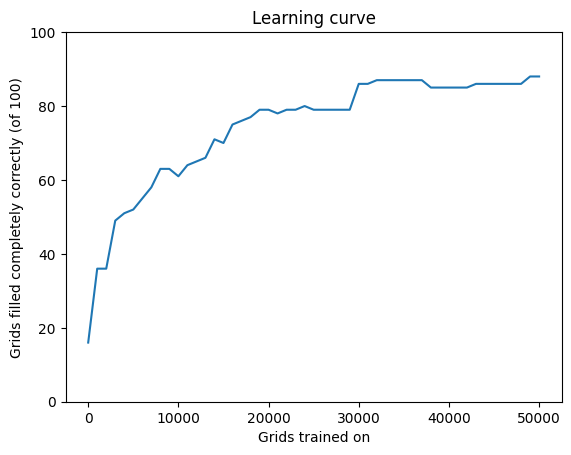

In [14]:
plt.title("Learning curve")
plt.xlabel("Grids trained on")
plt.ylabel("Grids filled completely correctly (of 100)")
plt.ylim([0, 100])
plt.plot(range(0, n_steps*grids_per_step+1, grids_per_step), progress)

print(f"Final performance:")
display(test_agent(agent))

On this amount of training, our agent is able to get a perfect score in roughly 90% of games. Training for longer improves this, and probably some tuning of hyperparameters could also help. But for now, let's move on to another way of solving this problem.